# <center>How different are short-term vs long-term users of Fitbod?

In this analysis, we look at 22 Fitbod users. We assume that we have all of the workout data for those users (I'll explain why that assumption looks reasonable). Hence the gap between their first and last recorded workout can be taken as their total length of time using the app.

We investigate whether people who have used the app for a long time differ from those that have not. Do they work out a different number times per week? Do they attempt different exercises when they work out?

There are many reasons why short-term and long-term users might differ:
- Users may get more / less ambitious with their workout routine over time.
- Irregular users may churn, leaving only those who work out the most frequently.
- The product may have recommended different exercises when the long-term users logged their first workouts vs what it recommends now.

Note: Differentiating between these reasons is beyond the scope of this analysis. We are just trying to measure whether differences exist.

In [49]:
import pandas as pd
from matplotlib import pyplot as plt
from datetime import datetime, timedelta
import numpy as np
import statsmodels.api as sm
from patsy import dmatrices

In [2]:
dataset = pd.read_csv("fitbod_DWALSH_20191114-114442.csv")
dataset

,singleSetId,weight,reps,distance,duration,elevationGain,setNumber,exerciseSetParseId,exerciseName,workoutId,workoutDate,fake_user_id
0,6wiXICPH68,0.000000,0.0,3061.000000,1269.0,23.700001,1,1p0URAWpXV,Running,ZsCb953QgI,2017-10-23,fake_id_280
1,YOfuh0bw2H,0.000000,0.0,3838.100098,1511.0,25.500000,1,VBNi6tOu3W,Running,n1T0dwNa15,2017-10-31,fake_id_280
2,7dhWRqsaCm,0.000000,0.0,4184.299805,600.0,0.000000,1,ygE4EASEmA,Cycling,ivd4qa8Syj,2017-11-01,fake_id_280
3,3pJr2AFpgO,127.000000,10.0,NaN,NaN,NaN,4,tYUWOKhCz1,Scissor Kick,WYIrwicBf6,2017-07-28,fake_id_281
4,P1TJ2sgKYQ,127.000000,10.0,NaN,NaN,NaN,4,DdIBK8Yquk,Side Bridge,fkRBieE0Pw,2017-07-21,fake_id_281
...,...,...,...,...,...,...,...,...,...,...,...,...
38208,G5I4EcuiEp,0.000000,7.0,NaN,NaN,NaN,2,LHdUCH8138,Pull Up,naC8OgOmh7,2017-09-29,fake_id_280
38209,5Bqrg9FoRs,0.000000,9.0,0.000000,0.0,0.000000,1,P4seuioY7A,Pull Up,eG8chtXuLA,2017-11-14,fake_id_280
38210,RYM1xuFNhP,0.000000,5.0,0.000000,0.0,0.000000,2,DXABiF6Bo0,Pull Up,JEi0G1o9Cv,2019-02-02,fake_id_291
38211,jaxWHiNJ0S,20.411681,6.0,0.000000,0.0,0.000000,1,7ohDP6CF6j,Barbell Incline Bench Press,qspicKEXoO,2018-09-12,fake_id_297


## How large is this data set?

22 users.

In [6]:
n_users = len(dataset.fake_user_id.unique())
n_users

22

We have nearly 100 workouts per user.

In [7]:
n_workouts = len(dataset.workoutId.unique())
n_workouts/n_users

93.95454545454545

For each user, we have 30 weeks of data on average.

In [60]:
def get_day_range(series):
    
    ## This function takes a pandas series of dates (saved as str)
    ## & computes the number of days between the first and last date
    
    all_times = series.apply(lambda x : datetime.strptime(x, '%Y-%m-%d'))
    time_range = all_times.max() - all_times.min()
    return time_range/timedelta(days = 1)

timespan_by_user_df = dataset.groupby("fake_user_id").workoutDate.apply(get_day_range)
timespan_by_user_df.name = "days_on_fitbod"
timespan_by_user_df = timespan_by_user_df.reset_index()
timespan_by_user_df.head()

,fake_user_id,days_on_fitbod
0,fake_id_280,274.0
1,fake_id_281,106.0
2,fake_id_282,5.0
3,fake_id_283,443.0
4,fake_id_284,364.0


In [61]:
mean_days_per_user = timespan_by_user_df.days_on_fitbod.mean()

# divide by 7 to get average number of weeks
mean_days_per_user/7.0

30.883116883116884

Note: 100 workouts over 30 weeks equals roughly one workout every other day. I doubt the average customer works out much more than that, so we can assume that we have all the workout data for each user in our sample.

The workouts contain nearly 20 sets on average.

In [19]:
n_sets = len(dataset.singleSetId.unique())
n_sets/n_workouts

18.462022254475084

Note: n_sets is slightly less than the number of rows in the dataset. Below is an example of set ID that corresponds to 2 different workouts...

In [22]:
dataset.singleSetId.value_counts()

VH0SyaUzK6    2
B1MkgGCS9a    2
icHolOb5tb    2
BKuF5kBwSO    2
I6hS79oipA    2
             ..
zIQVpG9NVE    1
lYDaEovdUH    1
r1SzJPmwIn    1
MC2UD3XPNU    1
T7IDiCAWQv    1
Name: singleSetId, Length: 38161, dtype: int64

In [25]:
dataset.loc[dataset.singleSetId == 'VH0SyaUzK6']

,singleSetId,weight,reps,distance,duration,elevationGain,setNumber,exerciseSetParseId,exerciseName,workoutId,workoutDate,fake_user_id
17238,VH0SyaUzK6,14.0,8.0,0.0,0.0,0.0,4,z7H89XkfTA,Skullcrusher,WK2u0Rvct6,2019-07-16,fake_id_291
33529,VH0SyaUzK6,14.0,8.0,0.0,0.0,0.0,4,z7H89XkfTA,Skullcrusher,SZ1vwsxcWV,2019-07-16,fake_id_291


## How often do different users work out?

In general, users range from about 1 to 10 times (wow!) per week.

In [62]:
workout_count_by_user = dataset.groupby("fake_user_id").workoutId.unique().apply(len)
workout_count_by_user.name = "total_count"
workout_count_by_user = workout_count_by_user.reset_index()
workout_count_by_user.head()

,fake_user_id,total_count
0,fake_id_280,167
1,fake_id_281,78
2,fake_id_282,6
3,fake_id_283,218
4,fake_id_284,124


In [64]:
workout_rate_by_user = workout_count_by_user.merge(timespan_by_user_df,
                                                  on = 'fake_user_id',
                                                  how = 'outer')
workout_rate_by_user['freq_per_week'] = 7.0*workout_rate_by_user.total_count/workout_rate_by_user.days_on_fitbod
workout_rate_by_user.head()

,fake_user_id,total_count,days_on_fitbod,freq_per_week
0,fake_id_280,167,274.0,4.266423
1,fake_id_281,78,106.0,5.150943
2,fake_id_282,6,5.0,8.400000
3,fake_id_283,218,443.0,3.444695
4,fake_id_284,124,364.0,2.384615


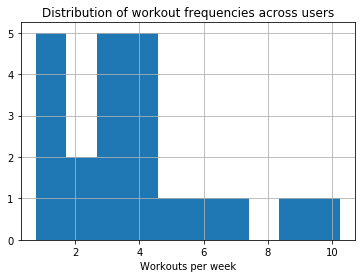

In [65]:
plt.title("Distribution of workout frequencies across users")
plt.xlabel("Workouts per week")
workout_rate_hist = workout_rate_by_user.freq_per_week.hist()

There is little correlation between how often users work out and how long they have been using Fitbod. Perhaps there is a slight drop off in workout frequency between new users vs people who have used the app for > 6 months. After that, the frequency is flat.

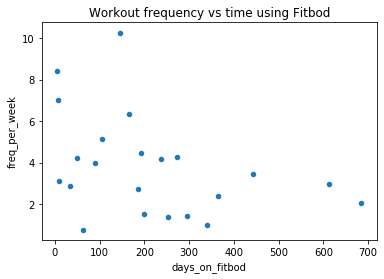

In [69]:
workout_rate_by_user.plot.scatter(x = "days_on_fitbod",
                                  y = "freq_per_week",
                                  title = "Workout frequency vs time using Fitbod")

In [71]:
workout_rate_by_user.corr()['days_on_fitbod']['freq_per_week']

-0.38525432518891645

## Do short-term vs long-term users attempt different exercises?

In general, users do a fairly wide range of exercises. No exercise makes up more than about 2% of sets.

In [81]:
def get_exercise_rates(df):
    
    ## This function takes as input a dataframe with a row for each set and a column for exercise_name
    ## It returns a dataframe with one row
    ## Each column gives the proportion of sets for that exercise
    
    total_sets = len(df)
    sets_by_exercise = df.groupby("exerciseName").apply(len)
    rate_df = sets_by_exercise/total_sets
    rate_df.name = 'rate'
    rate_df = rate_df.reset_index().transpose()
    rate_df.columns = rate_df.iloc[0]
    rate_df = rate_df.drop(['exerciseName'])
    return rate_df

overall_exercise_rates_df = get_exercise_rates(dataset)
overall_exercise_rates_df.sort_values(by = 'rate', axis = 1, ascending = False)

exerciseName,Back Squat,Barbell Bench Press,Push Up,Dumbbell Row,Lat Pulldown,Dumbbell Bench Press,Dumbbell Shoulder Press,Hammer Curls,Dumbbell Bicep Curl,Dumbbell Front Raise,...,Loop Band Shoulder Internal Rotation at 90°,Machine Overhead Press,Walking,Sled Push,Foam Roll Hip Abductors,Jog In Place,Jumping Jack,Plank Jack on Elbows,Machine Thigh Adductor,Foam Roll Quadriceps
rate,0.0205951,0.0198362,0.0185016,0.0178735,0.0170884,0.0145762,0.0137649,0.0136079,0.0132677,0.0132154,...,5.23382e-05,2.61691e-05,2.61691e-05,2.61691e-05,2.61691e-05,2.61691e-05,2.61691e-05,2.61691e-05,2.61691e-05,2.61691e-05


Short-term and long-term users do the same exercises.

Below we focus on the 5 most popular exercises, and we regress days_on_fitbod on the rate at which users attempt each of these. None of the 5 exercises are statistically significant.

In [75]:
exercise_rates_by_user_df = dataset.groupby("fake_user_id").apply(get_exercise_rates)
exercise_rates_by_user_df = exercise_rates_by_user_df.reset_index()
exercise_rates_by_user_df = exercise_rates_by_user_df.drop('level_1', axis = 1)
exercise_rates_by_user_df = exercise_rates_by_user_df.fillna(0)
exercise_rates_by_user_df.head()

,fake_user_id,Ab Rollout,Arnold Dumbbell Press,Back Extensions,Back Squat,Barbell Bench Press,Barbell Curl,Barbell Decline Bench Press,Barbell Incline Bench Press,Barbell Lunge,...,Hang Power Clean,Push Jerk,TRX Fallout,Weighted Torture Twist,Jog In Place,Jumping Jack,Lateral Box Jump,Reverse Lunge,Swimming,TRX Jump Squats
0,fake_id_280,0.000847,0.006351,0.016088,0.001270,0.006351,0.005504,0.005927,0.005927,0.001270,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,fake_id_281,0.000000,0.000000,0.000000,0.033065,0.000000,0.002296,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,fake_id_282,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,fake_id_283,0.000574,0.001723,0.000862,0.022401,0.046238,0.024411,0.002010,0.018093,0.001723,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,fake_id_284,0.000669,0.001339,0.016734,0.040161,0.040161,0.006024,0.000000,0.030790,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [100]:
## Restrict to the 5 most popular exercises

most_popular_exercises = overall_exercise_rates_df.sort_values(by = 'rate', axis = 1, ascending = False).columns.tolist()[:5]
most_popular_exercises

popular_exercise_rates_by_user_df = exercise_rates_by_user_df[['fake_user_id'] + most_popular_exercises]
popular_exercise_rates_by_user_df.head()

,fake_user_id,Back Squat,Barbell Bench Press,Push Up,Dumbbell Row,Lat Pulldown
0,fake_id_280,0.001270,0.006351,0.015241,0.020745,0.008891
1,fake_id_281,0.033065,0.000000,0.061998,0.033525,0.000000
2,fake_id_282,0.000000,0.000000,0.000000,0.054795,0.041096
3,fake_id_283,0.022401,0.046238,0.008616,0.020965,0.021827
4,fake_id_284,0.040161,0.040161,0.010710,0.020750,0.010040


In [101]:
regression_df = popular_exercise_rates_by_user_df.merge(timespan_by_user_df,
                                                                     on = 'fake_user_id',
                                                                     how = 'outer')

## Get the formula for the regression
## Patsy lets us handle column names with spaces by using 'Q()'
formula = 'days_on_fitbod ~ 1'
for exercise in most_popular_exercises:
    formula = formula + ' + Q("' + exercise + '")'
    
## Fit linear model
response, predictors = dmatrices(formula, regression_df)
model = sm.OLS(
    endog = response,
    exog = predictors).fit()
model.summary()

## In the summary, P>|t| gives the p-value for each exercise
## None of the p-values are significant at all

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         days_on_fitbod   R-squared:                       0.224
Model:                            OLS   Adj. R-squared:                 -0.019
Method:                 Least Squares   F-statistic:                    0.9214
Date:                Fri, 15 Nov 2019   Prob (F-statistic):              0.492
Time:                        16:45:38   Log-Likelihood:                -142.93
No. Observations:                  22   AIC:                             297.9
Df Residuals:                      16   BIC:                             304.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                  245.8050     91.397      2.689      0.016      52.052     439.558
Q("Back Squat")           3071.1205   3656.424      0.840      0.413   -4680.152    1.08e+04
Q("Barbell Bench Press") -2066.4478   3138.561     -0.658      0.520   -8719.900    4587.004
Q("Push Up")             -1751.3413   2433.134     -0.720      0.482   -6909.356    3406.673
Q("Dumbbell Row")        -5435.1065   4104.762     -1.324      0.204   -1.41e+04    3266.599
Q("Lat Pulldown")         5350.2171   3647.537      1.467      0.162   -2382.217    1.31e+04
==============================================================================
Omnibus:                        1.165   Durbin-Watson:                   1.477
Prob(Omnibus):                  0.558   Jarque-Bera (JB):                1.058
Skew:                           0.382   Prob(JB):                        0.589
Kurtosis:                       2.245   Cond. No.                         129.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Conclusion

We did not find strong differences between short and long-term users.

This could be due to the small number of users in our dataset. With more users, we could regress days_on_fitbod on all exercises (not just the top 5), which might produce a stronger signal. Similarly, we could consider non-linear associations between days_on_fitbod and workout frequency, and investigate a possible 6 month drop off point in more detail.

Even with these 22 users, there are columns in the dataset that I did not take advantage of. While all users are attempting the same exercises, perhaps we would find that long-term users hit more volume in each workout. This dataset also has interesting longitudinal data. We could examine how the workout frequency of each user develops over time, and how that connects with improvements in how much they can lift.